In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
import collections
from scipy.ndimage.filters import *
from PIL import Image

%matplotlib inline

In [2]:
################################
# STEP 1: GRAYSCALE + GAUSSIAN SMOOTHING

def image_to_gray(file_name):
    """ RETURNS GRAY CONVERSION OF IMAGE """
    return Image.open(file_name).convert('L')

def arr_of(image):
    """ RETURNS ARRAY OF IMAGE """
    return np.asarray(image, dtype=float)

def g_kernel(size, sigma):
    """ RETURNS KERNEL FOR GAUSSIAN BLURRING """
    k = size // 2
    x = np.mgrid[-k:k+1, -k:k+1][0]
    y = np.mgrid[-k:k+1, -k:k+1][1]
    H = np.exp(-(x**2.0 + y**2.0)/(2.0 * sigma**2.0)) / (2.0 * np.pi * sigma**2.0)
    return H

def GaussSmoothing(image, n, sigma):
    """ RETURNS IMAGE USING GAUSSIAN KERNEL """
    return Image.fromarray(convolve(image, g_kernel(n, sigma)))

################################
# STEP 2: IMAGE GRADIENT

def ImageGradient(smoothed_image):
    """ RETURNS MAGNITUDE & THETA ARRAYS OF BLURRED IMAGE """
#     used the sobel filters provided in class
    sob_x = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
    sob_y = np.array([[ 1, 2, 1],
                      [ 0, 0, 0],
                      [-1,-2,-1]])
    x = convolve(smoothed_image, sob_x)
    y = convolve(smoothed_image, sob_y)
    mag = (x**2.0 + y**2.0)**0.5
    theta = np.arctan2(y,x)
    return mag, theta

################################
# STEP 3: HIGH & LOW THRESHOLDS

def FindThreshold(mag, percentage_of_non_edge):
    """ USES CUMULATIVE DISTRIBUTION FUNCTION TO CALCULATE THRESHOLDS """
    T_high = 0
    [num, bins] = np.histogram(mag)
    cum_dist = np.cumsum(num)
    cum_dist_perc = cum_dist / cum_dist[-1]
    thresh = cum_dist_perc > percentage_of_non_edge
    T_high = min(bins[np.where(thresh == True)[0]])
    T_low = T_high * 0.5
    return round(T_low, 1), round(T_high, 1)

################################
# STEP 4: SUPRESS NONMAXIMA

def NonmaximaSupress(mag, theta):
    """ ELIMINATE POINTS THAT DON'T LIE ON IMPORTANT EDGES,
        THROUGH THE USE OF QUANTIZATION
    """
#     two possible methods: quantization / interpolation
#     I use quantization
    x,y = mag.shape
    clone = mag.copy()
    
#     convert theta (radians) to degrees
#     degree = theta * (180 / np.pi)
#     theta requires converting from angle to [0,4]
#     theta in RADIANS
    theta04 = (np.round(theta * (5.0 / np.pi)) + 5.0) % 5.0
    
    for i in range(1, x-1):
        for j in range(1, y-1):
            quant = theta04[i,j] % 4
            if i == 0 or j == 0 or i == x or j == y:
                clone[i,j] = 0
                continue
#             horizontal
            if quant == 0:
                if mag[i,j] <= mag[i,j-1]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i,j+1]:
                    clone[i,j] = 0
#             diagonal right
            elif quant == 1:
                if mag[i,j] <= mag[i+1,j-1]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i-1,j+1]:
                    clone[i,j] = 0
#             vertical
            elif quant == 2:
                if mag[i,j] <= mag[i-1,j]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i+1,j]:
                    clone[i,j] = 0
#             diagonal left
            elif quant == 3:
                if mag[i,j] <= mag[i-1,j-1]:
                    clone[i,j] = 0
                elif mag[i,j] <= mag[i+1,j+1]:
                    clone[i,j] = 0
    return clone

################################
# STEP 5: LINKING EDGES + TRESHOLDING

def EdgeLinking(supp, low, high):
    """ LINK STRONG EDGES WITH SLIGHTLY WEAKER ONES BASED ON
        THRESHOLD RESULTS
    """
    x,y = supp.shape
    strong_arr = np.asarray(supp > high, dtype='uint8')
    mid_arr = np.asarray(supp > low, dtype='uint8')
    strengths = strong_arr + mid_arr
    
    edges = strengths
    to_add = []
    
#     middle area
    for i in range(1, x-1):
        for j in range(1, y-1):
            if strengths[i,j] == 1:
                neighbors = strengths[i-1:i+2,j-1:j+2]
                if neighbors.max() == 2:
                    edges[i,j] = 2
                    to_add.append((i,j))
    
#     corners
    if edges[0,0] == 1:
        neighbors = edges[0:2,0:2]
        if neighbors.max() == 2:
            edges[0,0] = 2
    
    if edges[0,y-1] == 1:
        neighbors = edges[0:2,y-2:]
        if neighbors.max() == 2:
            edges[0,y-1] = 2
    
    if edges[x-1,0] == 1:
        neighbors = edges[x-2:,0:2]
        if neighbors.max() == 2:
            edges[x-1,0] = 2
    
    if edges[x-1,y-1] == 1:
        neighbors = edges[x-2:,y-2:]
        if neighbors.max() == 2:
            edges[x-1,y-1] = 2
    
#     sidelines
    for i in range(x):
        while 0 < i < x-1:
            if edges[0,i] == 1:
                neighbors = edges[0:2,i-1:i+2]
                if neighbors.max() == 2:
                    edges[0,i] = 2
            elif edges[i,0] == 1:
                neighbors = edges[i-1:i+2,0:2]
                if neighbors.max() == 2:
                    edges[i,0] = 2
            elif edges[x-1,i] == 1:
                neighbors = edges[x-2:x+1:,i-1:i+2]
                if neighbors.max() == 2:
                    edges[x-1,i] = 2
            elif edges[i,x-1] == 1:
                neighbors = edges[i-1:i+2,x-2:x+1:]
                if neighbors.max() == 2:
                    edges[i,x-1] = 2
            i += 1
    
    edges[edges == 1] = 0
    edges[edges == 2] = 255
    
    return edges

def canny(file_name, n, sigma, percent, t_low=0, t_high=0):
    """ FINAL. INPUTS:
        
        File_name,
        Gaussian Kernel Size,
        Sigma,
        Percentage of Non-Edge
    """
    img = image_to_gray(file_name)
    arr = arr_of(img)
    kern = g_kernel(n, sigma)
    smooth_img = GaussSmoothing(arr, n, sigma)
    
    mag,theta = ImageGradient(smooth_img)
    low,high = FindThreshold(mag, percent)
    if t_low != 0 or t_high != 0:
        low,high = t_low, t_high
    
    nonmax = NonmaximaSupress(mag, theta)
    final = EdgeLinking(nonmax, low, high)
    return final

In [3]:
test = Image.fromarray(canny('test.bmp', 25, 4, .9))
test2 = Image.fromarray(canny('test2.bmp', 25, 4, .9))
untitled = Image.fromarray(canny('Untitled.bmp', 25, 4, .9))
input_img = Image.fromarray(canny('input.bmp', 25, 4, .9))

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


In [4]:
def hough(image, quant):
    """ Hough transformation of lines
        REQUIRES A BINARY IMAGE!
    """
    
    m,n = image.shape
    theta_arr = np.deg2rad(np.arange(-90.0, 90.0, quant))
    pythag_dist = (m**2 + n**2)**0.5
    pythag_dist = np.asarray(pythag_dist, dtype=int).tolist()
    rho_arr = np.linspace(start = -pythag_dist,
                          stop = pythag_dist,
                          num = 2*pythag_dist)
    accumulator_arr = np.zeros((2*pythag_dist, len(theta_arr)), dtype=int)
    all_edges = image > 0
    
    theta_arr_sin = np.sin(theta_arr)
    theta_arr_cos = np.cos(theta_arr)
    y,x = np.where(all_edges == True)
    for i in range(0,len(x)):
        index_x = x[i]
        index_y = y[i]
        for each in range(len(theta_arr)):
            rho = pythag_dist + (index_x * theta_arr_cos[each] + index_y * theta_arr_sin[each])
            accumulator_arr[int(rho), each] += 1
    
    return accumulator_arr, rho_arr, theta_arr, image

def plot_hough(hough):
    """ PLOT ABOVE FUNCTION """
    acc = hough[0]
#     acc_inv = np.absolute(inv(acc))
    rho = hough[1]
    theta = hough[2]
    image = hough[3]
    
    left = np.rad2deg(theta[-1])
    right = np.rad2deg(theta[0])
    bottom = rho[-1]
    top = rho[0]
    
    fig,ax = plt.subplots(1,3,figsize=(15,10))
    ax[0].imshow(image, cmap='Greys_r')
    ax[0].set_title('CANNY EDGE DETECTION OF IMAGE')
    
    ax[1].plot(acc)
    ax[1].set_title('HISTOGRAM')
    
    ax[2].imshow(acc, cmap='Blues_r', extent=[left, right, bottom, top])
    ax[2].set_title('HOUGH TRANSFORM')
    ax[2].set_xlabel('DEGREES')
    ax[2].set_ylabel('DISTANCE')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    plt.show()


In [5]:
test_hough_1 = hough(arr_of(test), 1)
test_hough_3 = hough(arr_of(test), 5)
test2_hough = hough(arr_of(test2), 1)
untitled_hough = hough(arr_of(untitled), 1)
input_hough = hough(arr_of(input_img), 1)

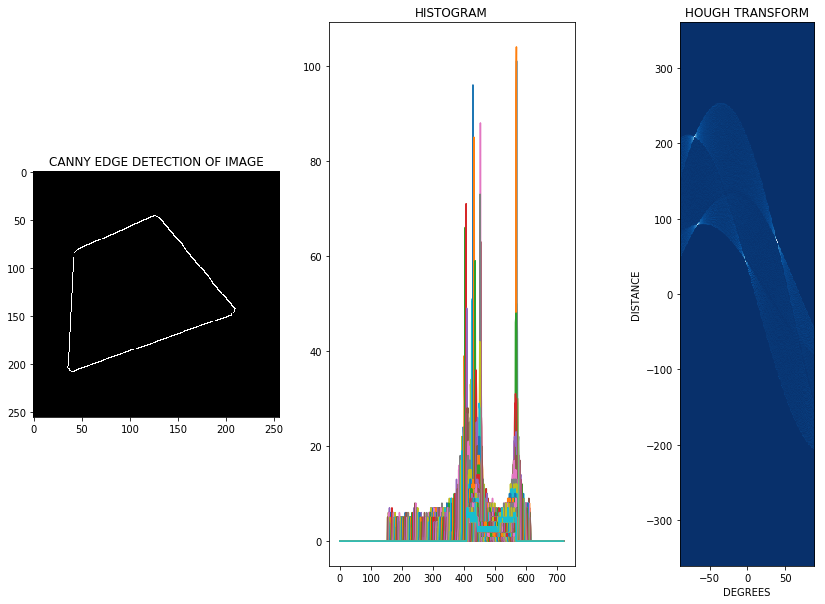

In [7]:
plot_hough(test_hough_1)

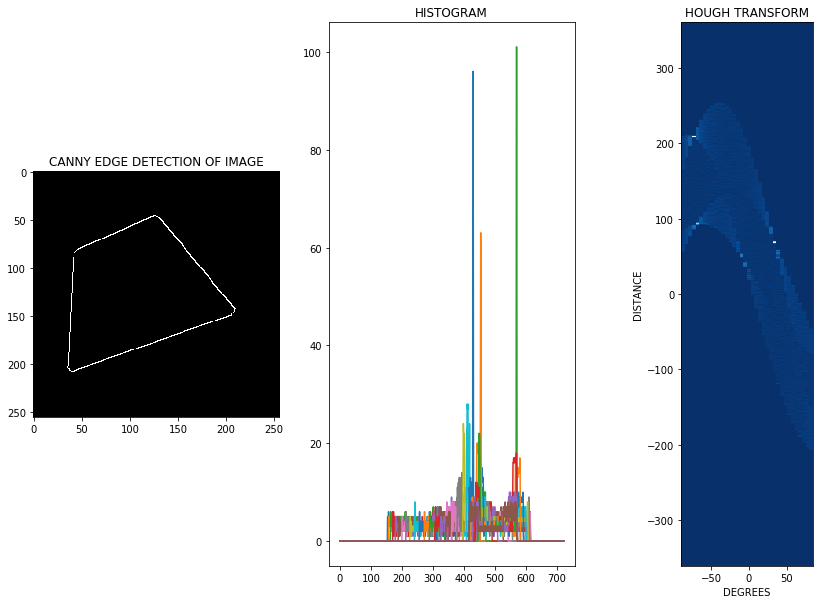

In [8]:
# QUANTIZING COMPARISON
plot_hough(test_hough_3)

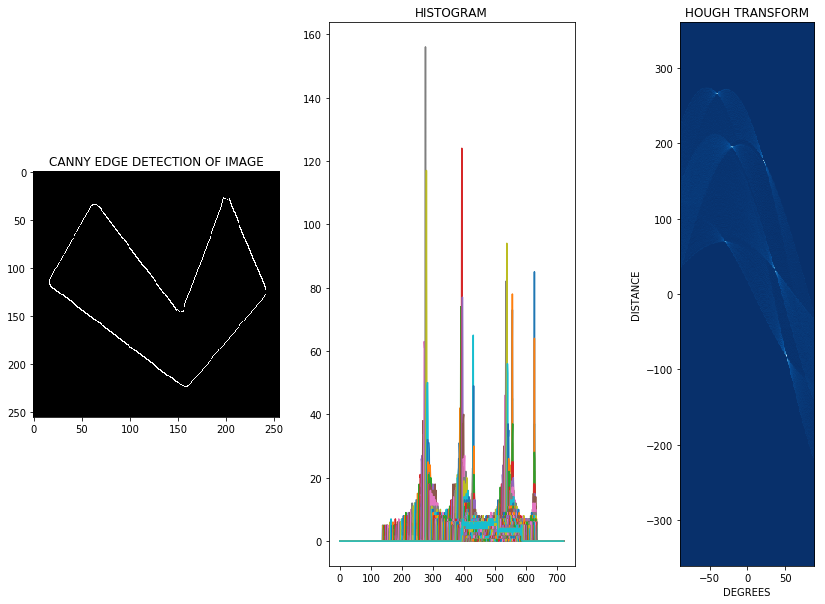

In [9]:
plot_hough(test2_hough)

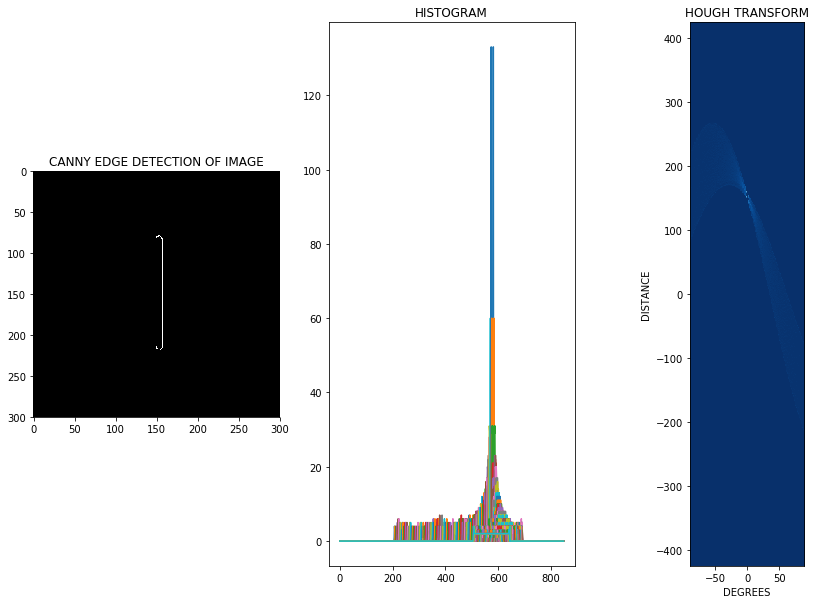

In [10]:
plot_hough(untitled_hough)

In [11]:
# THIS IS THE ANGLE OF THE GREATEST PEAK (ASSUME WE TELL IT TO FIND 2 LINES IN THE ABOVE IMAGE)
np.where(untitled_hough[0] == untitled_hough[0].flatten().max())[1]

array([90, 90])

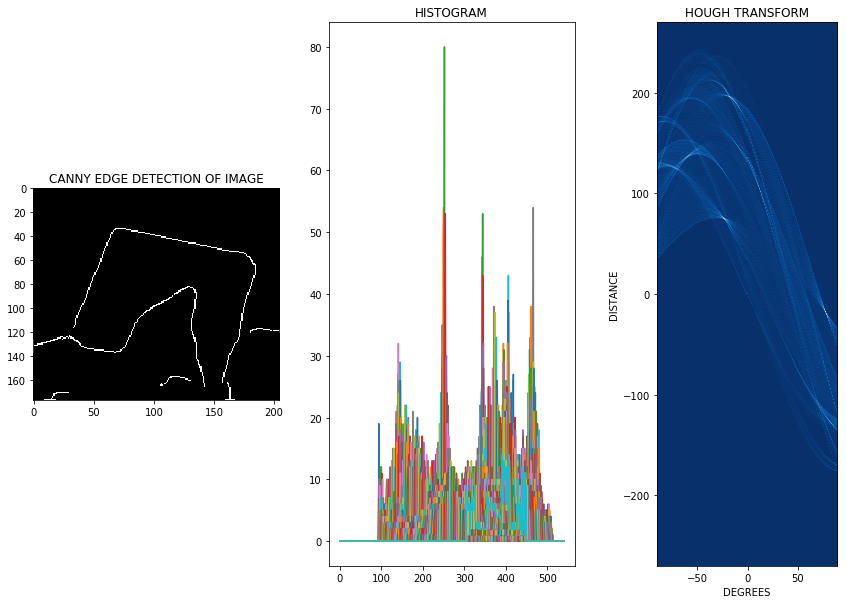

In [12]:
plot_hough(input_hough)